In [25]:
from Utils import supplier_config as sc, weather_config as wc
import requests
import json
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
from time import sleep

GET /v1/electricity-meter-points/{mpan}/meters/{serial_number}/consumption/    
GET /v1/gas-meter-points/{mprn}/meters/{serial_number}/consumption/  

In [5]:
s = requests.Session()

In [6]:
elec_r = s.get(sc.API_ROOT + f'/v1/electricity-meter-points/{sc.electric_MPAN}/meters/{sc.electric_serial_number}/consumption/?page_size=25000',
    auth=(sc.API_KEY,'')
 )
elec_r.raise_for_status()

In [148]:
elec_j = json.loads(elec_r.content)

elec_df = (pd.DataFrame(elec_j['results']))

elec_df['interval_start'] = pd.to_datetime(elec_df['interval_start'], utc=True)
elec_df['interval_end'] = pd.to_datetime(elec_df['interval_end'], utc=True)
elec_df.index = elec_df['interval_start']
day_elec_df = pd.DataFrame(elec_df['consumption'].resample('D').sum())
elec_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16561 entries, 2023-03-11 23:30:00+00:00 to 2022-02-25 00:00:00+00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   consumption     16561 non-null  float64            
 1   interval_start  16561 non-null  datetime64[ns, UTC]
 2   interval_end    16561 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 517.5 KB


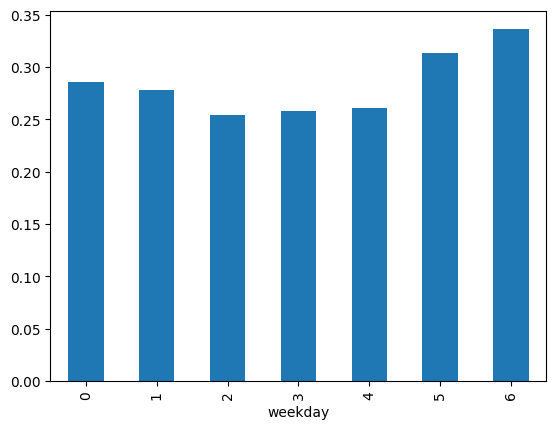

In [149]:
elec_df['weekday'] = elec_df['interval_start'].dt.dayofweek
# maybe get weekday names instead of numbers
elec_weekday_df = elec_df.groupby('weekday')['consumption'].mean()
_ = elec_weekday_df.plot.bar()

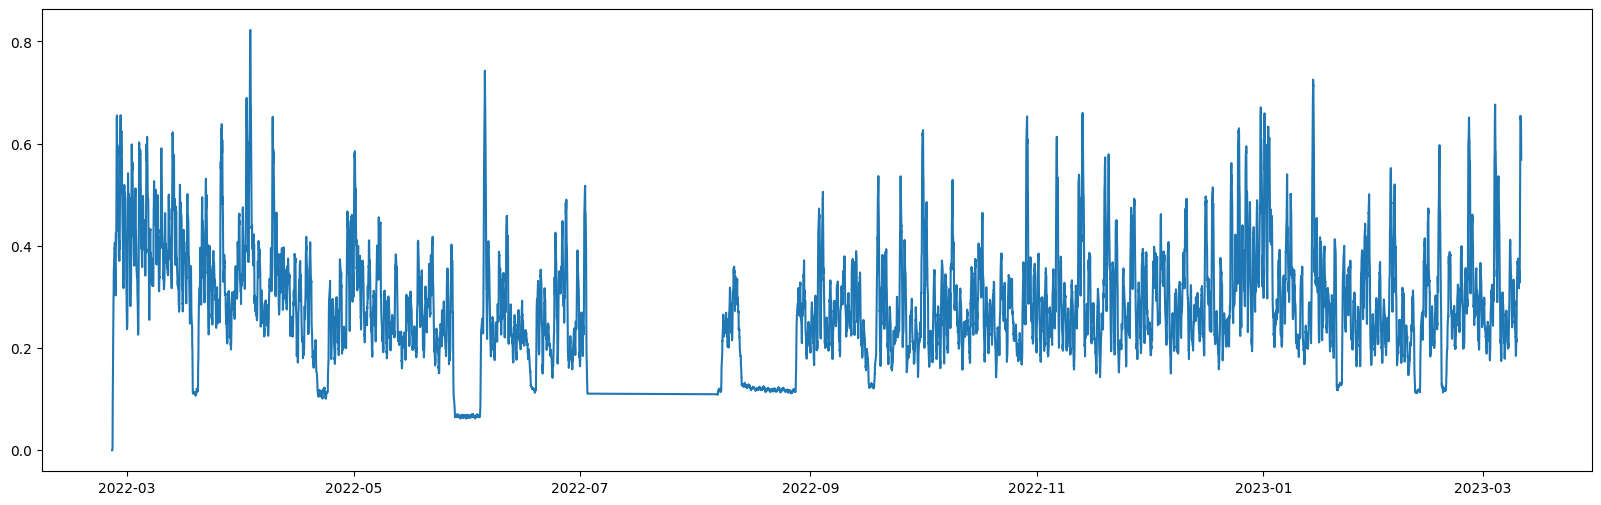

In [150]:

elec_df = elec_df.drop('interval_start', axis=1)
elec_df = elec_df.drop('interval_end', axis=1)
plt.figure(figsize=(20,6))
_ = plt.plot(elec_df['consumption'].rolling(window=4*7).mean())

In [151]:
gas_r = s.get(sc.API_ROOT + f'/v1/gas-meter-points/{sc.gas_MPRN}/meters/{sc.gas_serial_number}/consumption/?page_size=25000',
    auth=(sc.API_KEY,'')
 )
gas_r.raise_for_status()

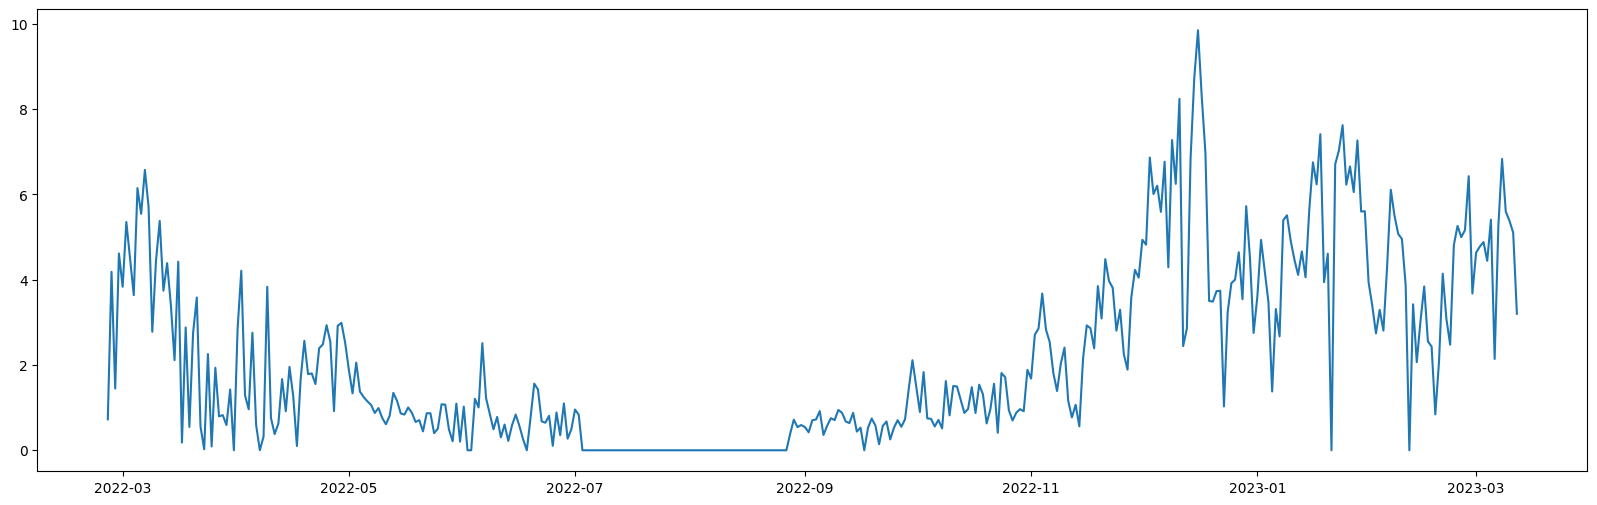

In [152]:
gas_j = json.loads(gas_r.content)
gas_df = (pd.DataFrame(gas_j['results']))
gas_df['interval_start'] = pd.to_datetime(gas_df['interval_start'], utc=True)

gas_df.index = gas_df['interval_start']

day_gas_df = pd.DataFrame(gas_df['consumption'].resample('D').sum())
day_gas_df['weekday'] = day_gas_df.index.dayofweek


gas_df = gas_df.drop('interval_start', axis=1)
gas_df = gas_df.drop('interval_end', axis=1)

plt.figure(figsize=(20,6))
_ = plt.plot(day_gas_df['consumption']) # .mean())


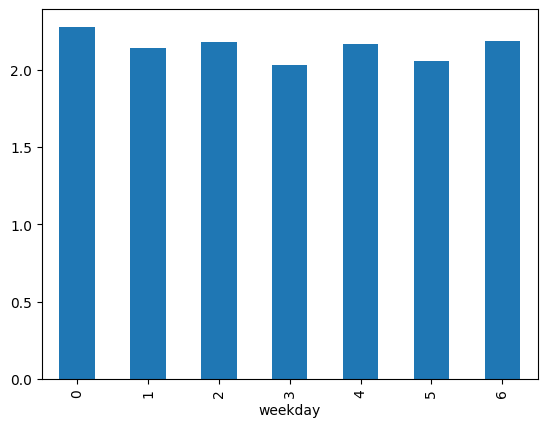

In [153]:

# maybe get weekday names instrad of numbers
gas_weekday_df = day_gas_df.groupby('weekday')['consumption'].mean()
_ = gas_weekday_df.plot.bar()

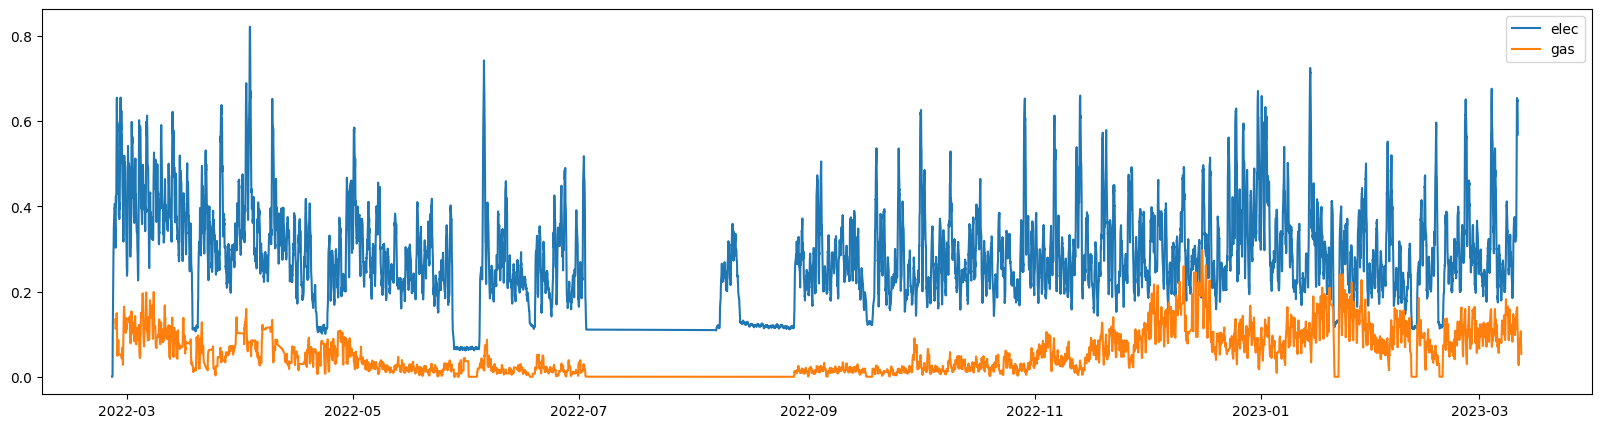

In [154]:
plt.figure(figsize=(20,5))
plt.plot(elec_df['consumption'].rolling(window=4*7).mean(), label='elec') # .plot(figsize=(20,6))
plt.plot(gas_df['consumption'].rolling(window=4*7).mean(), label='gas') # .plot(figsize=(20,6))
plt.legend()
plt.show()

In [155]:
for _d in range(1,365):
    d = dt.date.today() - dt.timedelta(days=_d)
    if not os.path.exists(os.path.join("Data", f"{d}_weather.json")):
        r = s.get(wc.API_ROOT.format(wc.home_lat, wc.home_lon, d))
        if 'data' in  json.loads(r.content):
            json.dump(json.loads(r.content), open(os.path.join("Data", f"{d}_weather.json"), "w"))
        else:
            # Some dates don't have data for our original coordinates.
            # Try somewhere nearby with a weather station
            r = s.get(wc.API_ROOT.format(wc.second_lat, wc.second_lon, d))
            if 'data' in  json.loads(r.content):
                json.dump(json.loads(r.content), open(os.path.join("Data", f"{d}_weather.json"), "w"))
        sleep(0.5)
    # print(d)
    # break


AttributeError: type object 'weather_config' has no attribute 'home_lat'

In [156]:
temp_data = []
t_df = None
for root, dirs, files in os.walk('Data'):
    for f in files:
        if f.endswith('.json'):
            
            j = json.load(open(os.path.join(root, f)))
            # print(j['data'][0])
            if 'data' in j:
                for data in j['data']:
                    temp_data.append({'date': data['date'], 'temperature': data['temperature'] })
        
        elif f.endswith('csv'):
            if t_df is None:
                t_df = (pd.read_csv(os.path.join(root, f))
                            .assign(date = lambda row: pd.to_datetime(row['date']))
                            .set_index('date')
                            )
            else:
                t_df = pd.concat(t_df, (pd.read_csv(os.path.join(root, f))
                            .assign(date = lambda row: pd.to_datetime(row['date']))
                            .set_index('date')))
        else:

            print(j)
            break

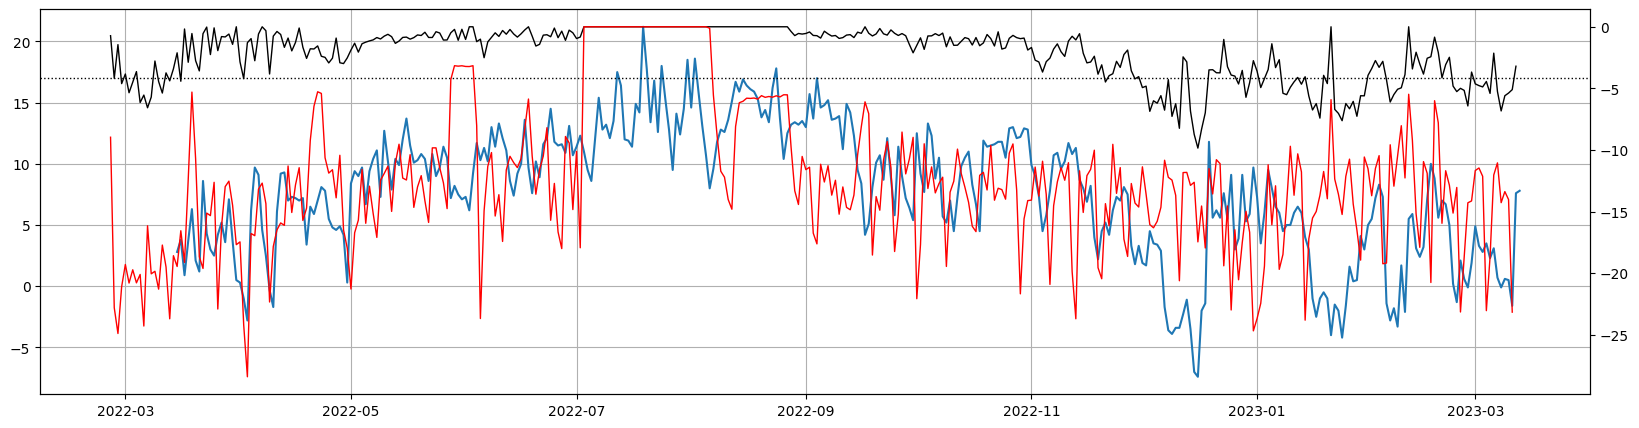

In [157]:
temp_df = pd.concat([t_df, (pd.DataFrame(temp_data)
 .assign(date = lambda row: pd.to_datetime(row['date'], utc=True))
 .set_index('date'))])

# plt.figure()
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.grid()
ax1.plot((temp_df
    .resample('D')
    .min()
    ))

plot_max=False
if plot_max:
    ax1.plot((temp_df
        .resample('D')
        .max()
        ))

ax1.axhline(17, ls=':', c='k', lw = 1)

ax2 = ax1.twinx()

# Invert the gas consumption to make it easier to read against temperature data
ax2.plot(day_gas_df['consumption'] * -1, c='k', lw=1)
ax2.plot(day_elec_df['consumption'] * -1, c='r', lw=1)

plt.show()

In [163]:
(temp_df
    .resample('D')
    .min()
    ).info(), day_gas_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2022-03-15 00:00:00+00:00 to 2023-03-13 00:00:00+00:00
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  364 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 381 entries, 2022-02-25 00:00:00+00:00 to 2023-03-12 00:00:00+00:00
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  381 non-null    float64
 1   weekday      381 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 17.0 KB


(None, None)

In [177]:
daily_consumption_df = pd.concat([day_gas_df, (temp_df
    .resample('D')
    .min()
    )], axis=1).dropna()

In [178]:
daily_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363 entries, 2022-03-15 00:00:00+00:00 to 2023-03-12 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  363 non-null    float64
 1   weekday      363 non-null    float64
 2   temperature  363 non-null    float64
dtypes: float64(3)
memory usage: 11.3 KB


In [179]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [223]:
daily_consumption_df['deg_below_12'] = pd.Series(12 - daily_consumption_df['temperature']).clip(0)

<Axes: >

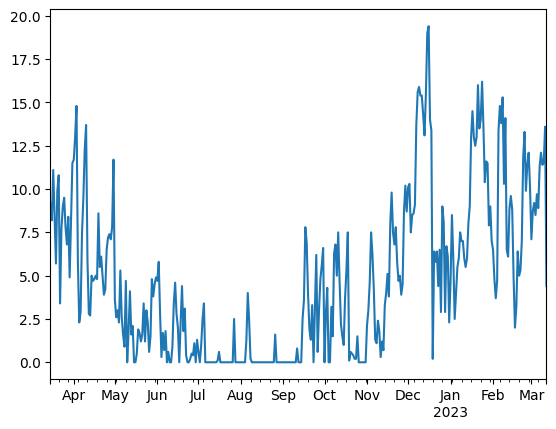

In [224]:
daily_consumption_df['deg_below_12'].plot()

In [225]:
daily_consumption_df['consumption_minmax'] = MinMaxScaler().fit_transform(np.array(daily_consumption_df['consumption']).reshape(-1, 1)).flatten()
daily_consumption_df['temperature_minmax'] = MinMaxScaler().fit_transform(np.array(daily_consumption_df['deg_below_12']).reshape(-1, 1)).flatten() + 1

In [229]:
daily_consumption_df['consumption_by_temp'] = MinMaxScaler().fit_transform(
    np.array(daily_consumption_df['consumption_minmax'] / daily_consumption_df['temperature_minmax']).reshape(-1, 1)
).flatten() + 1

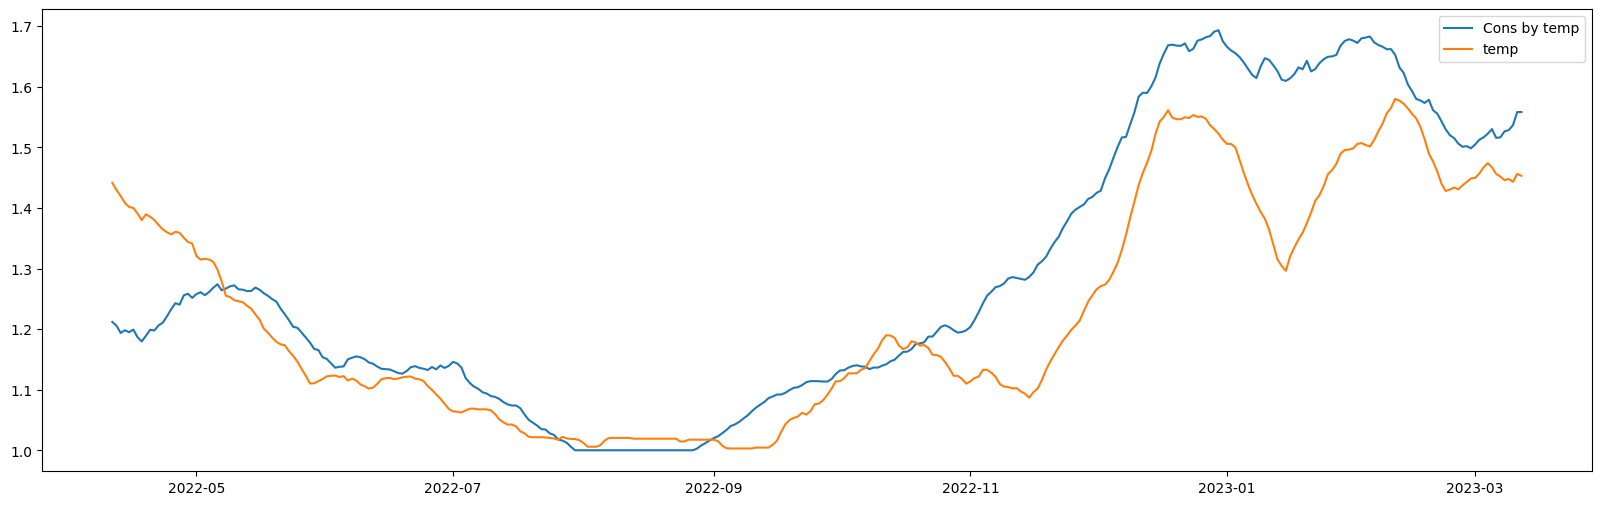

In [230]:
plt.figure(figsize=(20,6))
# .rolling(window=28, center=False).mean()
plt.plot(daily_consumption_df['consumption_by_temp'].rolling(window=28, center=False).mean(), label="Cons by temp")
# plt.plot(daily_consumption_df['consumption_minmax'].rolling(window=28, center=False).mean(), label = 'Cons')
plt.plot(daily_consumption_df['temperature_minmax'].rolling(window=28, center=False).mean(), label = 'temp')
plt.legend()
plt.show()